*JSC270, Winter 2020 - Prof. Chevalier*

# <center>  Assignment 2 - Yelp  </center>
<center> Karl Hendrik Nurmeots, February 19, 2020 </center>



***

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
import seaborn as sns
import simplejson as json
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

In [3]:
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = [15,7]

# Introduction

[Yelp](https://www.yelp.com/) is a business directory service and crowd-sourced review forum.

# The Yelp Dataset

For this report we will be using the [Yelp dataset](https://www.yelp.com/dataset/challenge). **For this report to compile, you must download the data from the website and place it in extracted form in the 'data' directory!**. This requires you to provide your email and name.

Per the [Yelp dataset license](https://s3-media1.fl.yelpcdn.com/assets/srv0/engineering_pages/06cb5ad91db8/assets/vendor/yelp-dataset-agreement.pdf), one is allowed to create a report of the data such as this one only for academic purposes. Any sort of disclosure or sharing of the dataset itself is strictly prohibited - this is a private dataset. Any use of the dataset must not disparage Yelp.

A more detailed overview of the dataset can be found on the [dataset documentation page](https://www.yelp.com/dataset/documentation/main). Due to the comprehensive extent of the dataset we will only provide a short insight into what the dataset contains. The dataset consists of 6 JSON files: 

`business.json` contains information about each establishment in the dataset such as the business' name, ID, location (address and coordinates), Yelp rating and review count, attributes (e.g. if the business provides a takeout service), category, and opening hours.

`review.json` contains information about each review, namely the author ID, business reviewed ID, rating, date, full review text, and the number of "useful", "funny" and "cool" votes the review has recieved. Author ID maps to the corresponding user in user.json, and business ID maps to the business in business.json.

`user.json` contains information about users' IDs, first names, their friends' user IDs, and info about the feedback they have recieved on their reviews (e.g. total "useful" votes).

`checkin.json` contains each business' ID and a collection of timestamps when users have checked in at that business. Again, the business ID maps to business.json.

`tip.json` contains information about short tips that users have posted, and is structured similarly to review.json. Tips are essentially very short reviews, but do not give a numeric rating about the business. Instead of tracking the number of different votes, the number of "compliments" the tip has recieved is tracked.

`photo.json` contains metadata about photos users have posted: the business' ID the picture is about, the author's user ID, the picture's caption and label (e.g. "food"). 

For this analysis, we will only use `business.json` and `review.json`.

In [27]:
def json_to_dataframe(file: str, nrows = 0) -> pd.DataFrame:
    """Returns a Pandas dataframe from the JSON file located at <file>."""
    with open(file, 'r', encoding="utf8") as f:
        if nrows == 0:
            content = f.readlines()
        else:
            content = []
            for i in range(nrows):
                content.append(f.readline())
        
    return pd.DataFrame([json.loads(row) for row in content])

In [28]:
# Reading in the 2 JSON files
business = json_to_dataframe("data/business.json", 500)
review = json_to_dataframe("data/review.json", 500)

In [33]:
business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


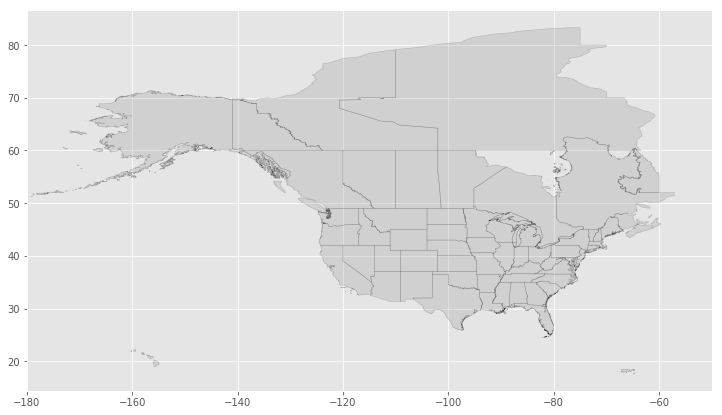

In [60]:
# USA and Canada political boundaries shapefile from:
# https://www.sciencebase.gov/catalog/item/51bf5940e4b0eb321c798ec9

shp = gpd.read_file('data/USA_Canada_ShapefileMerge.shx')
ax = shp.plot(edgecolor='k', color='grey', alpha =0.2)
ax.set_xlim(-180, -50)
plt.show()

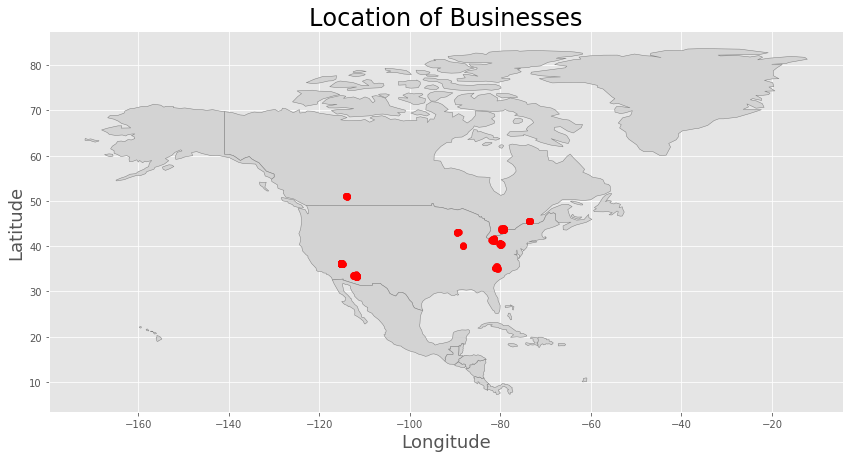

In [75]:
gdf = gpd.GeoDataFrame(
    business, geometry=gpd.points_from_xy(business.longitude, business.latitude))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent == 'North America'].plot(
    color='lightgrey', edgecolor='grey')

gdf.plot(ax=ax, color='red')

plt.title("Location of Businesses", fontsize=24)
plt.xlabel("Longitude", fontsize=18)
plt.ylabel("Latitude", fontsize=18)
plt.show()

As we can see, we only have US and Canada businesses. Different zip code formats, so we can distinguish country.

In [ ]:
def get_country(row: pd.Series) -> str:
    """Given a pd.Series representing a row about a business, re"""